# Imports

In [787]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from upos import upos
from scipy.stats import chi2_contingency, chi2

# Constants + Helper Functions

In [788]:
CONJUNCTION_COLORS = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

CONJUNCTION_COLORS = {
    "and": "#9B5DE5",
    "or": "#00BBF9",
    "but": "#38b000",
    "nor": "#d90429",
}

LIKE_UNLIKE_COLORS = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

CATEGORY_COLORS = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

CONJUNCTIONS = ['and', 'or', 'but'] #, 'nor']

CATEGORIES = [upos.NOUN, upos.VERB, upos.ADJ, upos.ADV]

In [789]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [790]:
def get_wordnet_dfs(df):
    '''
    Get five DataFrames for each WordNet relation (synonymy, antonymy,
    hypernymy, co-hyponymy, entailment) using examples from the given
    input df.

    @param df (DataFrame): input of raw coordination samples
    @return (5-tuple of DataFrames): tuple containing a DataFrame for each
        WordNet relation (synonymy_df, antonymy_df, hypernymy_df,
        cohyponymy_df, entailment_df)
    '''
    
    # Get like coordinations
    likes = utils.likes_df(df)

    # Finding closures over wordnet relations produces redundant search warnings
    # We'll just filter these warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Get wordnet relations for like coordinations
        synonymy_df = utils.analyze_synonymy(likes)
        antonymy_df = utils.analyze_antonymy(likes)
        hypernymy_df = utils.analyze_hypernymy(likes)
        cohyponymy_df = utils.analyze_cohyponymy(likes)
        entailment_df = utils.analyze_entailment(likes)

    return (synonymy_df, antonymy_df, hypernymy_df, cohyponymy_df, entailment_df)

In [791]:
def chi2_from_table(table):
    N = sum([sum(l) for l in table])
    print('N={}'.format(N))

    print(table)
    stat, p, dof, expected = chi2_contingency(table)
    print('Degrees of Freedom = %d' % dof)
    print(expected)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' %
          (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')


def chi2_by_conjunction(relation_df, freq_func, conjunctions=CONJUNCTIONS):

    group1_freqs = []
    group2_freqs = []

    for conjunction in conjunctions:

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_from_table([group1_freqs, group2_freqs])


def chi2_by_category(relation_df, freq_func, categories=CATEGORIES):

    group1_freqs = []
    group2_freqs = []

    for category in categories:

        df = relation_df.copy()
        df = df.loc[(df['1st Conjunct Category'] == category) &
                    (df['2nd Conjunct Category'] == category)]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_from_table([group1_freqs, group2_freqs])

### Plotting Distributions on Single-Bar Charts

In [792]:
def plot_single_bar(labels, freqs, title, outfile, colors):

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars
    freqs = [f * 100 for f in freqs]

    _, ax = plt.subplots()
    rects1 = ax.bar(x, freqs, width, color=colors)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')

In [793]:
def distribution_by_conjunction(relation_df, freq_func, relation_title, outfile,
    conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs = []

    for conjunction in conjunctions:

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freqs.append(freq_func(df))

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CONJUNCTION_COLORS.values())

In [794]:
def distribution_by_category(relation_df, freq_func, relation_title, outfile,
    categories=CATEGORIES, source=None):

    labels = []
    freqs = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        labels.append('Nominal')
        freqs.append(freq_func(nouns))

    if upos.VERB in categories:
        labels.append('Verbal')
        freqs.append(freq_func(verbs))

    if upos.ADJ in categories:
        labels.append('Adjectival')
        freqs.append(freq_func(adjps))

    if upos.ADV in categories:
        labels.append('Adverbial')
        freqs.append(freq_func(advps))

    title = 'Percentages of Coordinations with {}\nby Syntactic Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CATEGORY_COLORS.values())

### Plotting Distributions for Double-Bar Charts

In [795]:
def plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile):

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    freqs1 = [f * 100 for f in freqs1]
    freqs2 = [f * 100 for f in freqs2]

    _, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, freqs1, width,
                    label=sublabels[0])
    rects2 = ax.bar(x + width/2, freqs2, width,
                    label=sublabels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.savefig(outfile, bbox_inches='tight')

In [796]:
def double_distribution_by_conjunction(relation_df, freq_func, relation_title,
    sublabels, outfile, conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    print(source) if source is not None else print('All Data')
    print()

    for conjunction in conjunctions:
        print(conjunction)

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freq1, freq2 = freq_func(df)
        freqs1.append(freq1)
        freqs2.append(freq2)

        print()

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    print()

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

In [797]:
def double_distribution_by_category(relation_df, freq_func, relation_title,
    sublabels, outfile, categories=CATEGORIES, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    print(source) if source is not None else print('All Data')
    print()

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        print('Nominal')
        labels.append('Nominal')
        freq1, freq2 = freq_func(nouns)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.VERB in categories:
        print('Verbal')
        labels.append('Verbal')
        freq1, freq2 = freq_func(verbs)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADJ in categories:
        print('Adjectival')
        labels.append('Adjectival')
        freq1, freq2 = freq_func(adjps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADV in categories:
        print('Adverbial')
        labels.append('Adverbial')
        freq1, freq2 = freq_func(advps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    title = 'Percentages of Coordinations with {}\nby Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    print()

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

# Load Data and Get WordNet Relations

In [798]:
# GUM
gum_samples = get_df_from_path('csv/GUM/*.csv')
gum_synonymy_df, gum_antonymy_df, gum_hypernymy_df, gum_cohyponymy_df, gum_entailment_df \
    = get_wordnet_dfs(gum_samples)

# EWT
ewt_samples = get_df_from_path('csv/EWT/*.csv')
ewt_synonymy_df, ewt_antonymy_df, ewt_hypernymy_df, ewt_cohyponymy_df, ewt_entailment_df \
    = get_wordnet_dfs(ewt_samples)

# PUD
pud_samples = get_df_from_path('csv/PUD/*.csv')
pud_synonymy_df, pud_antonymy_df, pud_hypernymy_df, pud_cohyponymy_df, pud_entailment_df \
    = get_wordnet_dfs(pud_samples)

# All sources
all_synonymy_df = pd.concat(
    [gum_synonymy_df, ewt_synonymy_df, pud_synonymy_df], axis=0, ignore_index=True)
all_antonymy_df = pd.concat(
    [gum_antonymy_df, ewt_antonymy_df, pud_antonymy_df], axis=0, ignore_index=True)
all_hypernymy_df = pd.concat(
    [gum_hypernymy_df, ewt_hypernymy_df, pud_hypernymy_df], axis=0, ignore_index=True)
all_cohyponymy_df = pd.concat(
    [gum_cohyponymy_df, ewt_cohyponymy_df, pud_cohyponymy_df], axis=0, ignore_index=True)
all_entailment_df = pd.concat(
    [gum_entailment_df, ewt_entailment_df, pud_entailment_df], axis=0, ignore_index=True)

utils.pretty_print(all_synonymy_df[all_synonymy_df['Synonyms?']], 'rtf/synonyms.rtf')
utils.pretty_print(all_antonymy_df[all_antonymy_df['Antonyms?']], 'rtf/antonyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['1st Conjunct Hypernym?']], 'rtf/1st_hypernyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['2nd Conjunct Hypernym?']], 'rtf/2nd_hypernyms.rtf')
utils.pretty_print(all_cohyponymy_df[all_cohyponymy_df['Co-hyponyms?']], 'rtf/co-hyponyms.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['1st Conjunct Entails 2nd?']], 'rtf/1st_entailments.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['2nd Conjunct Entails 1st?']], 'rtf/2nd_entailments.rtf')

# Synonymy

In [799]:
def get_synonyms_freqs(df, raw=False):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    if raw:
        return (syns_count, tot - syns_count)
        
    return syns_count / tot if tot != 0 else 0

### By Conjunction

N=6920
[[163, 23, 18], [5424, 681, 611]]
Degrees of Freedom = 2
[[ 164.70346821   20.75375723   18.54277457]
 [5422.29653179  683.24624277  610.45722543]]
probability=0.950, critical=5.991, stat=0.285
Independent (fail to reject H0)
significance=0.050, p=0.867
Independent (fail to reject H0)


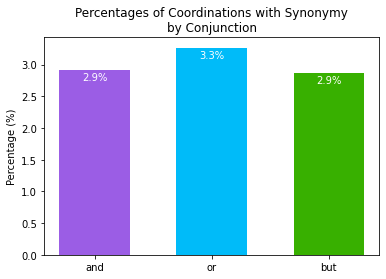

In [800]:
def synonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_conjunction(all_synonymy_df, get_synonyms_freqs)
synonym_conjunction_distribution(all_synonymy_df, 'charts/synonymy_by_conjunction.pdf')
# synonym_conjunction_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_conjunction.pdf', source='GUM')
# synonym_conjunction_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_conjunction.pdf', source='EWT')
# synonym_conjunction_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_conjunction.pdf', source='PUD')

### By Category

N=6937
[[38, 150, 15, 2], [2439, 3563, 625, 105]]
Degrees of Freedom = 3
[[7.31995099e+01 1.09725386e+02 1.89130748e+01 3.16202970e+00]
 [2.40380049e+03 3.60327461e+03 6.21086925e+02 1.03837970e+02]]
probability=0.950, critical=7.815, stat=33.949
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


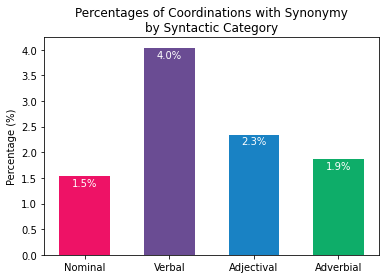

In [801]:
def synonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_category(all_synonymy_df, get_synonyms_freqs)
synonym_category_distribution(all_synonymy_df, 'charts/synonymy_by_category.pdf')
# synonym_category_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_category.pdf', source='GUM')
# synonym_category_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_category.pdf', source='EWT')
# synonym_category_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_category.pdf', source='PUD')

# Antonymy

In [802]:
def get_antonyms_freqs(df, raw=False):
    # Get antonyms
    ants = df.loc[(df['Antonyms?'] == True)]
    ants.reset_index(drop=True, inplace=True)

    # Get counts
    count_ants = len(ants.index)
    tot = len(df.index)

    if raw:
        return (count_ants, tot - count_ants)
    return count_ants / tot if tot != 0 else 0


### By Conjunction

N=722
[[38, 13, 1], [567, 51, 52]]
Degrees of Freedom = 2
[[ 43.5734072    4.60941828   3.81717452]
 [561.4265928   59.39058172  49.18282548]]
probability=0.950, critical=5.991, stat=19.468
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


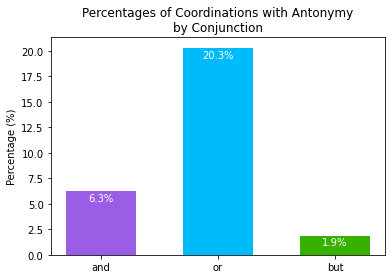

In [803]:
def antonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_antonyms_freqs, "Antonymy", outfile, source=source)

chi2_by_conjunction(all_antonymy_df, get_antonyms_freqs)
antonym_conjunction_distribution(all_antonymy_df, 'charts/antonymy_by_conjunction.pdf')
# antonym_conjunction_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_conjunction.pdf', source='GUM')
# antonym_conjunction_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_conjunction.pdf', source='EWT')
# antonym_conjunction_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_conjunction.pdf', source='PUD')

### By Category

N=723
[[37, 15], [583, 88]]
Degrees of Freedom = 1
[[ 44.59197787   7.40802213]
 [575.40802213  95.59197787]]
probability=0.950, critical=3.841, stat=8.531
Dependent (reject H0)
significance=0.050, p=0.003
Dependent (reject H0)


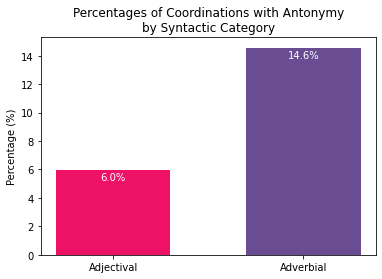

In [804]:
def antonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_antonyms_freqs, "Antonymy",
        outfile, categories=[upos.ADJ, upos.ADV], source=source)

chi2_by_category(all_antonymy_df, get_antonyms_freqs, categories=[upos.ADJ, upos.ADV])
antonym_category_distribution(all_antonymy_df, 'charts/antonymy_by_category.pdf')
# antonym_category_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_category.pdf', source='GUM')
# antonym_category_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_category.pdf', source='EWT')
# antonym_category_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_category.pdf', source='PUD')

# Hypernymy

In [805]:
def get_hypernymy_freqs(df, raw=False):
    tot = len(df.index)
    df = df.loc[(df['1st Conjunct Hypernym?'] == True) | (df['2nd Conjunct Hypernym?'] == True)]
    df = df.loc[(df['1st Conjunct Hypernym?']) != (df['2nd Conjunct Hypernym?'])]

    # Get 1st conjunct hypernymy
    hyps1 = df.loc[(df['1st Conjunct Hypernym?'] == True)]
    hyps1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct hypernymy
    hyps2 = df.loc[(df['2nd Conjunct Hypernym?'] == True)]
    hyps2.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps1 = len(hyps1.index)
    count_hyps2 = len(hyps2.index)
    
    if raw:
        return (count_hyps1, count_hyps2)

    return (count_hyps1 / tot, count_hyps2 / tot) if tot != 0 else (0,0)

### By Conjunction

N=742
[[277, 37, 42], [301, 49, 36]]
Degrees of Freedom = 2
[[277.31536388  41.26145553  37.42318059]
 [300.68463612  44.73854447  40.57681941]]
probability=0.950, critical=5.991, stat=1.923
Independent (fail to reject H0)
significance=0.050, p=0.382
Independent (fail to reject H0)
All Data

and

or

but




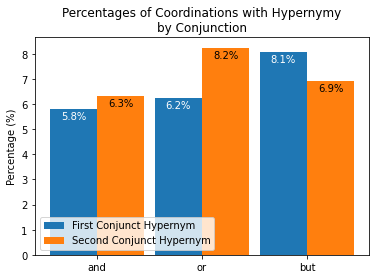

In [806]:
def hypernymy_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_hypernymy_freqs, "Hypernymy",
    ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile, source=source)

chi2_by_conjunction(all_hypernymy_df, get_hypernymy_freqs)
hypernymy_conjunction_distribution(all_hypernymy_df, 'charts/hypernymy_by_conjunction.pdf')
# hypernymy_conjunction_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_conjunction.pdf', source='GUM')
# hypernymy_conjunction_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_conjunction.pdf', source='EWT')
# hypernymy_conjunction_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_conjunction.pdf', source='PUD')

### By Category

N=743
[[112, 244], [117, 270]]
Degrees of Freedom = 1
[[109.72274563 246.27725437]
 [119.27725437 267.72274563]]
probability=0.950, critical=3.841, stat=0.080
Independent (fail to reject H0)
significance=0.050, p=0.777
Independent (fail to reject H0)
All Data

Nominal
Verbal



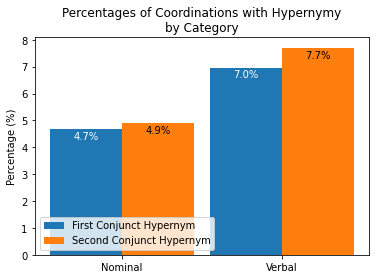

In [807]:
def hypernymy_category_distribution(df, outfile, source=None):
    double_distribution_by_category(df, get_hypernymy_freqs, "Hypernymy",
        ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

chi2_by_category(all_hypernymy_df, get_hypernymy_freqs, categories=[upos.NOUN, upos.VERB])
hypernymy_category_distribution(all_hypernymy_df, 'charts/hypernymy_by_category.pdf')
# hypernymy_category_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_category.pdf', source='GUM')
# hypernymy_category_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_category.pdf', source='EWT')
# hypernymy_category_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_category.pdf', source='PUD')

# Co-Hyponymy

In [808]:
def get_cohyponyms_freqs(df, raw=False):
    # Get co-hyponymy
    hyps = df.loc[(df['Co-hyponyms?'] == True)]
    hyps.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps = len(hyps.index)
    tot = len(df.index)

    if raw:
        return (count_hyps, tot - count_hyps)
        
    return count_hyps / tot if tot != 0 else 0

### By Conjunction

N=6174
[[837, 101, 92], [4129, 532, 483]]
Degrees of Freedom = 2
[[ 828.47100745  105.60252672   95.92646582]
 [4137.52899255  527.39747328  479.07353418]]
probability=0.950, critical=5.991, stat=0.539
Independent (fail to reject H0)
significance=0.050, p=0.764
Independent (fail to reject H0)


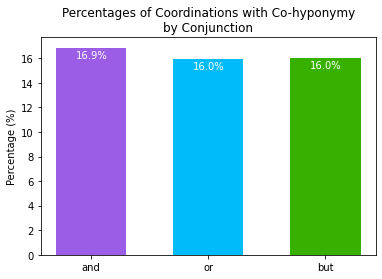

In [809]:
def cohyponymy_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_cohyponyms_freqs, "Co-hyponymy", outfile, source=source)

chi2_by_conjunction(all_cohyponymy_df, get_cohyponyms_freqs)
cohyponymy_conjunction_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_conjunction.pdf')
# cohyponymy_conjunction_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_conjunction.pdf', source='GUM')
# cohyponymy_conjunction_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_conjunction.pdf', source='EWT')
# cohyponymy_conjunction_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_conjunction.pdf', source='PUD')

### By Category

N=6190
[[280, 751], [2197, 2962]]
Degrees of Freedom = 1
[[ 412.56655897  618.43344103]
 [2064.43344103 3094.56655897]]
probability=0.950, critical=3.841, stat=84.563
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


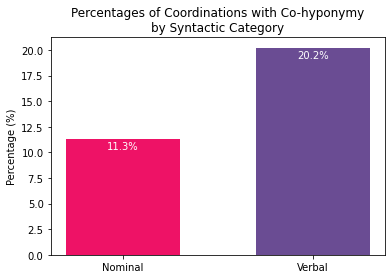

In [810]:
def cohyponymy_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_cohyponyms_freqs, "Co-hyponymy", outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

chi2_by_category(all_cohyponymy_df, get_cohyponyms_freqs, categories=[upos.NOUN, upos.VERB])
cohyponymy_category_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_category.pdf')
# cohyponymy_category_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_category.pdf', source='GUM')
# cohyponymy_category_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_category.pdf', source='EWT')
# cohyponymy_category_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_category.pdf', source='PUD')

# Entailment

In [811]:
def get_entailment_freqs(df, raw=False):
    tot = len(df.index)
    
    df = df.loc[(df['1st Conjunct Entails 2nd?'] == True) | (df['2nd Conjunct Entails 1st?'] == True)]
    df = df.loc[(df['1st Conjunct Entails 2nd?']) != (df['2nd Conjunct Entails 1st?'])]

    # Get 1st conjunct entailment
    entl1 = df.loc[(df['1st Conjunct Entails 2nd?'] == True)]
    entl1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct entailment
    entl2 = df.loc[(df['2nd Conjunct Entails 1st?'] == True)]
    entl2.reset_index(drop=True, inplace=True)

    # Get counts
    count_entl1 = len(entl1.index)
    count_entl2 = len(entl2.index)
    
    if raw:
        return (count_entl1, count_entl2)

    return (count_entl1 / tot, count_entl2 / tot) if tot != 0 else (0,0)

# By Conjunction

N=33
[[9, 0, 4], [17, 1, 2]]
Degrees of Freedom = 2
[[10.24242424  0.39393939  2.36363636]
 [15.75757576  0.60606061  3.63636364]]
probability=0.950, critical=5.991, stat=2.768
Independent (fail to reject H0)
significance=0.050, p=0.251
Independent (fail to reject H0)
All Data

and

or

but




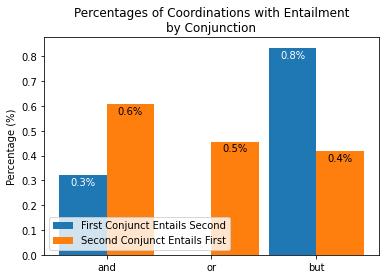

In [812]:
def entailment_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_entailment_freqs, "Entailment",
        ('First Conjunct Entails Second', 'Second Conjunct Entails First'), outfile,
        source=source)

chi2_by_conjunction(all_entailment_df, get_entailment_freqs)
entailment_conjunction_distribution(all_entailment_df, 'charts/entailment_by_conjunction.pdf')
# entailment_conjunction_distribution(gum_entailment_df, 'charts/GUM_entailment_by_conjunction.pdf', source='GUM')
# entailment_conjunction_distribution(ewt_entailment_df, 'charts/EWT_entailment_by_conjunction.pdf', source='EWT')
# entailment_conjunction_distribution(pud_entailment_df, 'charts/PUD_entailment_by_conjunction.pdf', source='PUD')